# Week 6: Using scikit-learn for Naive Bayes and Logistic Regression

Things we have built painfully from scratch can be done easily and quickly using the ```scikit-learn``` module.

It can do the word-counting for us, transforming a column of tweets into a term-document matrix.

Then it can run classification, using a variety of algorithms.

```Scikit-learn``` can even do cross-validation automatically! Our lives are about to get a lot easier. 

(Of course, that means our goals can also become more ambitious.)

Let's start by reading in our handy dataset of Trump tweets. Then I'll simplify the dataframe to reduce the number of columns. I'll also create a "dummy" numeric column to represent the "class" each tweet belongs to, using the technique illustrated by Kevin Markham's linear regression notebook.


In [1]:
import os, math
import pandas as pd

cwd = os.getcwd()
print('Current working directory: ' + cwd + '\n')
      
relativepath = os.path.join('..', 'data', 'weekfour', 'trump.csv')
trump = pd.read_csv(relativepath)

def trump_test(a_data_frame, rowidx):
    ''' Just a function that translates complex statusSource strings
    into a simpler class label.
    '''
    
    if 'iphone' in a_data_frame['statusSource'][rowidx]:
        return 'iphone'
    elif 'android' in a_data_frame['statusSource'][rowidx]:
        return 'android'
    else:
        return 'other'

# Let's create a simple data frame with just two columns,
# the tweet text and the source.

tweet_text = trump['text']
source = []
for idx in trump.index:
    source.append(trump_test(trump, idx))

    

# We created source as a list. To add it to a data frame, we need
# to make it a Series, which is the Pandas way of thinking about
# an indexed list.
source = pd.Series(source, index = trump.index)

# Now let's create the Trump data frame.
tdf = pd.concat([tweet_text, source], axis = 1)
tdf.columns = ['text', 'source']

# Let's filter it to get rid of any rows that aren't iphone
# or android
tdf = tdf[(tdf['source'] == 'android') | (tdf['source'] == 'iphone')]

# Now to create a dummy numeric column. We'll need this later.
tdf['isandroid'] = tdf.source.map({'android':1, 'iphone':0})

tdf.head()

Current working directory: /Users/rmorriss/Documents/datahum/code



,text,source,isandroid
0,My economic policy speech will be carried live...,android,1
1,"Join me in Fayetteville, North Carolina tomorr...",iphone,0
2,"#ICYMI: ""Will Media Apologize to Trump?"" https...",iphone,0
3,"Michael Morell, the lightweight former Acting ...",android,1
4,The media is going crazy. They totally distort...,android,1


### Using scikit-learn for word counting.

Classifiers are going to demand two arguments: 

A) a matrix where rows are observations and columns are variables.
B) a column of class labels for the observations.

For text classification, (A) is a document-term matrix. Fortunately ```scikit-learn``` has a ```CountVectorizer()``` function that can produce this automatically.

For full documentation, see:
http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
countvec = CountVectorizer(max_features = 100)

# The max_features argument tells the vectorizer to return
# a matrix with columns for only the p most common words.

# Because this matrix could get quite large on a collection
# of long documents, the vectorizer returns it in a special
# 'sparse' format. But we're going to convert that to an ordinary
# DataFrame for ease of inspection and manipulation.

sparse_matrix = countvec.fit_transform(tdf['text'])
termdoc = pd.DataFrame(sparse_matrix.toarray(), columns=countvec.get_feature_names())
termdoc.head()



,about,again,all,am,america,amp,and,are,as,at,...,what,when,who,why,will,win,with,would,you,your
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.cross_validation import cross_val_score
mnb = MultinomialNB()
scores = cross_val_score(mnb, termdoc.as_matrix(), tdf['isandroid'], cv=10)
print(sum(scores) / len(scores))
scores

0.799902661722


array([ 0.86428571,  0.8       ,  0.79856115,  0.77697842,  0.76978417,
        0.8057554 ,  0.81294964,  0.84172662,  0.81884058,  0.71014493])

## Question to ask about this
This is all well and good; I once again think I understand how the code works, and what each bit of the code is doing (although to be fair the last cell above is all from scikit-learn and the functions and methods for that are completely foreign to me. It's pretty clear what a function like MultinomialNB() does, but it's not so clear what is happening under the hood. Obviously Ted's code from last week let me see what the Naive Bayes is actually calculating, so that's good at least.

But the big problem here is that I'm not clear on what the output of the cross_val is. I think these are measurements of how successful the Bayes method was at classifying the tweets into trump and not-trump. That said, I think the most important piece of the Bayes is the actual model, which I take to be stored in the variable mnb. In the from-scratch Bayes functions that Ted coded last week, we were able to see the model, which was a dataframe with the various coefficients, especially the log_pos and log_neg which were what we used to test the model against the test set. Here in the scikit-learn environment, we no longer have this model and I'm confused about what is happening now. I'm not even sure I understand what that array is. 

A couple other questions:
- Ted went to great lengths to turn the matrix from CountVectorizer() into a regular dataframe. However it looks above like he turns it back into a matrix ['termdoc.as_matric()] in order to pass it into the cross_val_score. Why not just leave it as a matrix?
- What is mnb?

### Regularized logistic regression

I won't fully explain logistic regression here. I hope I have time to sketch a little on the whiteboard. But very briefly, it's a way of *mapping* linear regression onto a finite space between 0 and 1. This allows a regression algorithm to do the work of classification. It is sometimes more accurate than naive Bayes. (More importantly, it produces well-*calibrated* probabilistic predictions. When logistic regression tells you an instance has a 60% chance of being in class X, that number is actually meaningful. Naive Bayes, on the other hand, has a tendency to exaggerate, seeing instances as all the way toward one class or the other.) 

*Regularizing* the regression basically means adding a degree of deliberate fuzz to prevent overfitting. This is done by penalizing large weights in the model (so your decision boundary can't become all volatile and wiggly.)

The upshot of all this is that regularized logistic regression gives you a parameter to tune: the regularization constant, ```C```, controlling the degree of fuzziness. In the scikit-learn implementation, small values of ```C``` mean strong (fuzzy) regularization.

http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

In [4]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = .1)
scores = cross_val_score(lr, termdoc.as_matrix(), tdf['isandroid'], cv=10)
print(sum(scores) / len(scores))
scores

0.827251664507


array([ 0.88571429,  0.82142857,  0.79856115,  0.82014388,  0.77697842,
        0.84892086,  0.86330935,  0.8705036 ,  0.81884058,  0.76811594])

## Homework exercise 1: grid search

Write a function that runs logistic regression repeatedly, in order to find the optimal value of C (regularization constant) for a given term-doc matrix and column of class labels. Use ten-fold cross-validation, as above.

For this problem, it makes sense to search the space between 30 and .0003. Try using this list of possible settings:
[30, 10, 3, 1, 0.3, 0.1, 0.03, 0.01, 0.003, 0.001, .0003]

Your function should return two values: the optimal parameter for C, and the accuracy achieved at the optimal parameter.

This is called "grid search" because you could, theoretically, optimize multiple parameters at once, with nested loops. Here, however, we're just optimizing one -- so it's more like "line search."

## Pseudocode
- set oldresult = .5 [a low accuracy]
- list = [possible settings]
- write for loop for setting in possible settings:
- set c to setting
- set variable lr to the result of running the LogisticRegression function with argument(c = setting)
- run the cross validation
- result = sum of scores divided by length of scores (or the average score)
- now test to see if result is > oldresult. If so, set the oldresult to result, else continue. return oldresult.


In [5]:
# first just make sure you can make this loop work, not worrying about defining a function. 
oldresult = .5
list = [30, 10, 3, 1, .3, .1, .03, .01, .003, .001, .0003]
result_list = []
for setting in list:
    c = setting
    lr = LogisticRegression(C = c)
    scores = cross_val_score(lr, termdoc.as_matrix(), tdf['isandroid'], cv=10)
    average_score = (sum(scores)/ len(scores))
    result_list.append([average_score, c])
    print('Average score for {} is: {}'.format(c, average_score))
    print(scores)

sorted_list = sorted(result_list, key=lambda tup:(-tup[0], tup[1]))
print('The optimal C value for the linear regression is {} which gives an average score of {}'.format(sorted_list[0][1], sorted_list[0][0]))



Average score for 30 is: 0.8107197223587589
[ 0.83571429  0.79285714  0.79136691  0.79856115  0.76978417  0.84172662
  0.88489209  0.86330935  0.81884058  0.71014493]
Average score for 10 is: 0.8128832834353634
[ 0.83571429  0.8         0.78417266  0.81294964  0.76258993  0.84172662
  0.88489209  0.86330935  0.82608696  0.7173913 ]
Average score for 3 is: 0.8136183475579785
[ 0.83571429  0.8         0.77697842  0.81294964  0.75539568  0.84172662
  0.88489209  0.86330935  0.83333333  0.73188406]
Average score for 1 is: 0.8193636146983035
[ 0.85714286  0.80714286  0.77697842  0.81294964  0.77697842  0.84172662
  0.88489209  0.85611511  0.84782609  0.73188406]
Average score for 0.3 is: 0.8272827948821068
[ 0.88571429  0.80714286  0.79856115  0.82733813  0.78417266  0.84892086
  0.85611511  0.84892086  0.84057971  0.77536232]
Average score for 0.1 is: 0.8272516645069038
[ 0.88571429  0.82142857  0.79856115  0.82014388  0.77697842  0.84892086
  0.86330935  0.8705036   0.81884058  0.76811594

In [8]:
# Now write a function
def optimal_c_log_regression(tdmatrix, column):
    oldresult = .5
    list = [30, 10, 3, 1, .3, .1, .03, .01, .003, .001, .0003]
    result_list = []
    for setting in list:
        c = setting
        lr = LogisticRegression(C = c)
        scores = cross_val_score(lr, tdmatrix.as_matrix(), column, cv=10)
        average_score = (sum(scores)/ len(scores))
        result_list.append([average_score, c])
    sorted_list = sorted(result_list, key=lambda tup:(-tup[0], tup[1]))
#     return result_list[0][1], result_list[0][0]
    return sorted_list[0][1], sorted_list[0][0]
        
optimal_c_log_regression(termdoc, tdf['isandroid'])

(0.3, 0.82728279488210676)

## Homework exercise 2: battle of the algorithms

Which works better: logistic regression or naive Bayes?
Does it matter how many features we use?

Write a loop that generates term-doc matrices for the Trump dataset with different numbers of features, from 200 to 4000, increasing by 200 each time

```for i in range(200, 4200, 200):```

For each term-doc matrix, calculate the accuracy of naive Bayes, and also the accuracy of logistic regression (using your optimizer function from exercise 1 to get the best accuracy). Save both accuracies in a pair of growing lists.

When the loop is complete, plot the accuracy of both classifiers. The x axis should be ```number of features,``` the y axis should be ```accuracy```, and you should have two lines: one for naive Bayes, and one for logistic regression.

## My solution
I think what I want to do with this is write a function for the naive bayes, so that I can run the loop, create my term-doc matrix, and then save two lists with the number of features and accuracy corresponding to each of my methods.

In [9]:
# First write a function for the NB
def NB(tdmatrix, column):
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.cross_validation import cross_val_score
    mnb = MultinomialNB()
    scores = cross_val_score(mnb, tdmatrix.as_matrix(), column, cv=10)
    return sum(scores) / len(scores)

NB(termdoc, tdf['isandroid'])

0.79990266172155455

In [10]:
# Now put the two functions together
Bayes_Accuracies = []
LR_Accuracies = []
feature_nums = []
from sklearn.feature_extraction.text import CountVectorizer
for i in range(200, 4200, 200):
    countvec = CountVectorizer(max_features = i)
    sparse_matrix = countvec.fit_transform(tdf['text'])
    termdoc = pd.DataFrame(sparse_matrix.toarray(), columns=countvec.get_feature_names())
    
    # now run the functions
    bayes = NB(termdoc, tdf['isandroid'])
    Bayes_Accuracies.append(bayes)
    
    lr2 = optimal_c_log_regression(termdoc, tdf['isandroid'])
    LR_Accuracies.append(lr2[1])
    # note that above this has to retrieve the accuracy from the tuple, so that's what the index is for.
    
    feature_nums.append(i)
    
print(feature_nums)
print(Bayes_Accuracies)
print(LR_Accuracies)


[200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000, 2200, 2400, 2600, 2800, 3000, 3200, 3400, 3600, 3800, 4000]
[0.79846358937694561, 0.80856688562193724, 0.80568926225479243, 0.81001623545883794, 0.80930187526997044, 0.81289385882598264, 0.81865454220474554, 0.81650140756959644, 0.8186544677301637, 0.81505734542800534, 0.81577163114229112, 0.81433792096757374, 0.81577163114229112, 0.81649105560272273, 0.81721569328388222, 0.81722083203002815, 0.81794025649045976, 0.81866481969703742, 0.81937910541132308, 0.81937910541132308]
[0.82727758166137888, 0.83160448039084256, 0.8308744060652099, 0.83447167731653182, 0.83592080372968702, 0.83519624052310948, 0.83302761517494073, 0.83520152821841909, 0.83592102715343253, 0.83664045161386424, 0.83664045161386424, 0.83664045161386424, 0.83592102715343253, 0.83592102715343253, 0.83664045161386424, 0.83664566483459191, 0.8373650892950234, 0.83737022804116956, 0.83664559036001018, 0.83736501482044168]


## What this is
So what you see above are three lists: the feature nums, and then the results of the tests for each of the Bayes and the Log Regression w/ the optimizer. The tests took a really long time. But I think the numbers look plausible. Now the only thing left to do is set the lists up as a dataframe and then use matplotlib to plot it. 

In [11]:
# make a dataframe

feature_nums = pd.Series(feature_nums)
Bayes_Accuracies = pd.Series(Bayes_Accuracies)
LR_Accuracies = pd.Series(LR_Accuracies)

battle_of_algorithms = pd.concat([feature_nums, Bayes_Accuracies, LR_Accuracies], axis = 1)
battle_of_algorithms.columns = ['feature_nums', 'Bayes_Scores', 'Log_Regression_Scores']

battle_of_algorithms    

,feature_nums,Bayes_Scores,Log_Regression_Scores
0,200,0.798464,0.827278
1,400,0.808567,0.831604
2,600,0.805689,0.830874
3,800,0.810016,0.834472
4,1000,0.809302,0.835921
5,1200,0.812894,0.835196
6,1400,0.818655,0.833028
7,1600,0.816501,0.835202
8,1800,0.818654,0.835921
9,2000,0.815057,0.836640


# Now make the plot
It took me a while to remember how to do this plotting business, but I finally got it.

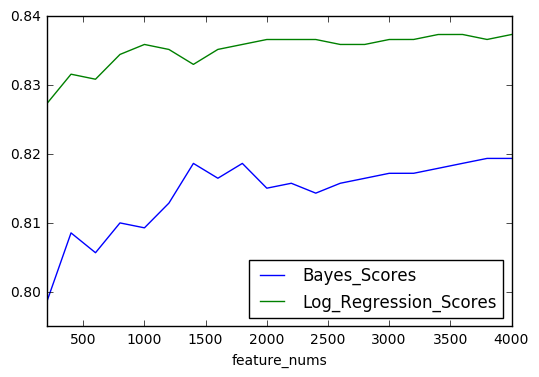

In [12]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# battle_of_algorithms.plot(kind = 'line', x = 'feature_nums', y= 'Bayes_Scores')
# battle_of_algorithms.plot(kind = 'line', x = 'feature_nums', y= 'Log_Regression_Scores')
battle_of_algorithms.plot(kind = 'line', x = 'feature_nums')
plt.show()

## Analysis
In the battle of the algorithms, it seems somewhat inconclusive; the Bayes did better at low feature numbers, but log regression overtook the Bayes as the feature_nums increased. 

I am sure I could have done this much more efficiently and without a bunch of the lines that I wrote; indeed, I think this is pretty un-Pythonic. I would not be too surprised if I did it wrong, in fact. At the same time, the numbers look okay. I still need to get the intuition of the Bayes down. Maybe one thing we could discuss is how you've used this in your work, a real-life example. The examples you gave the other day about biography vs. fiction might help me to understand the use of the model. Is the idea that you run the log regression or the bayes model on corpuses from different points in time, and then see how the model performs for any given time? Do you use the same model while comparing mid 19th century to early 20th century corpuses, or do you re-run the functions? These kinds of intuitions are still not totally clear to me. Thanks Ted!